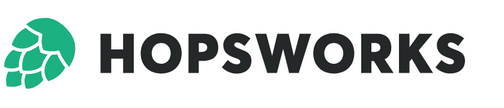

# Feature Pipeline using Synthetic Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/featurestoreorg/serverless-ml-course/blob/main/nbs/01-module/1a_feature_groups.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

## 🗒️ This notebook is divided in 2 sections:
1. Reading the synthetic credit card data and feature engineeing,
2. Write the Pandas DataFrames to the feature groups in the feature store.


In [ ]:
#!pip install -U hopsworks --quiet
#!pip install -U faker --quiet

In [ ]:
import pandas as pd
import datetime
import hopsworks
from sml import synthetic_data
import random
pd.options.mode.chained_assignment = None

In [ ]:
start_time = (datetime.datetime.now() - datetime.timedelta(hours=24)).strftime("%Y-%m-%d %H:%M:%S")
print(start_time)

In [ ]:
#end_time = (datetime.datetime.now() - datetime.timedelta(hours=24)).strftime("%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(end_time)

In [ ]:
synthetic_data.FRAUD_RATIO = random.uniform(0.001, 0.005)
synthetic_data.TOTAL_UNIQUE_USERS = 1000
synthetic_data.TOTAL_UNIQUE_TRANSACTIONS = 54000
synthetic_data.CASH_WITHRAWAL_CARDS_TOTAL = 2000 
synthetic_data.TOTAL_UNIQUE_CASH_WITHDRAWALS = 1200
synthetic_data.START_DATE=start_time
synthetic_data.END_DATE=end_time

credit_cards = synthetic_data.generate_list_credit_card_numbers()
credit_cards_df = synthetic_data.create_credit_cards_as_df(credit_cards)
profiles_df = synthetic_data.create_profiles_as_df(credit_cards)
trans_df = synthetic_data.create_transactions_as_df(credit_cards)

## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Fraudulent transactions can differ from regular ones in many different ways. Typical red flags would for instance be a large transaction volume/frequency in the span of a few hours. It could also be the case that elderly people in particular are targeted by fraudsters. To facilitate model learning you will create additional features based on these patterns. In particular, you will create two types of features:
1. **Features that aggregate data from different data sources**. This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.
2. **Features that aggregate data from multiple time steps**. An example of this could be the transaction frequency of a credit card in the span of a few hours, which is computed using a window function.

Let's start with the first category.

In [ ]:
fraud_labels = trans_df.copy()[["tid", "cc_num", "datetime", "fraud_label"]]
fraud_labels

In [ ]:
from sml import cc_features

fraud_labels.datetime = fraud_labels.datetime.map(lambda x: cc_features.date_to_timestamp(x))
fraud_labels

In [ ]:
trans_df

In [ ]:
trans_df.drop(['fraud_label'], inplace = True, axis=1)

In [ ]:
trans_df = cc_features.card_owner_age(trans_df, profiles_df)
trans_df = cc_features.expiry_days(trans_df, credit_cards_df)
trans_df = cc_features.activity_level(trans_df, 1)

In [ ]:
window_len = 4
window_aggs_df = cc_features.aggregate_activity_by_hour(trans_df, window_len)

Next, you will create features that for each credit card aggregate data from multiple time steps.

Yoy will start by computing the distance between consecutive transactions, lets call it `loc_delta`.
Here you will use the [Haversine distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances) to quantify the distance between two longitude and latitude coordinates.

Next lets compute windowed aggregates. Here you will use 4-hour windows, but feel free to experiment with different window lengths by setting `window_len` below to a value of your choice.

In [ ]:
project = hopsworks.login()
fs = project.get_feature_store()

To create a feature group you need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [ ]:
trans_fg = fs.get_feature_group(name="cc_trans_fraud", version=2)
trans_fg.insert(trans_df, write_options={"wait_for_job" : False})

In [ ]:
window_aggs_fg = fs.get_feature_group(name=f"cc_trans_fraud_{window_len}h", version=2)
window_aggs_fg.insert(window_aggs_df, write_options={"wait_for_job" : False})

In [ ]:

labels_fg = fs.get_feature_group(name="transactions_fraud_label", version=2)
labels_fg.insert(fraud_labels)